** *Sales* *Prediction* **
You are provided with daily historical sales data.
The task is to forecast the total amount of products sold in every shop for the test set. 

---



Importing Packages


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import math, time, datetime
from math import sqrt
import numpy as np 
import pandas as pd
# from scipy import stats

from matplotlib import pyplot as plt
import missingno as msno
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, roc_auc_score, 
                             precision_recall_curve, auc, log_loss, accuracy_score, f1_score, mean_squared_error)
from sklearn.feature_selection import (mutual_info_classif, SelectKBest, chi2, RFE, RFECV)
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

Read CSV files That contains the daily historical sales data into DataFrames  

File descriptions :

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

* sample_submission.csv - a sample submission file in the correct format.

* items.csv - supplemental information about the items/products.

* item_categories.csv - supplemental information about the items categories.

* shops.csv- supplemental information about the shops.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

--------------------------------------------------------------------

Data fields

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January  2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

This dataset is permitted to be used for any purpose, including commercial use.

In [ ]:
!git clone https://github.com/SAIDBELAKBIR37/Future-sales-Prediction

Cloning into 'Future-sales-Prediction'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [ ]:
!unzip /content/Future-sales-Prediction/Data/items.csv.zip
!unzip /content/Future-sales-Prediction/Data/sales_train.csv.zip
!unzip /content/Future-sales-Prediction/Data/test.csv.zip
!unzip /content/Future-sales-Prediction/Data/sample_submission.csv.zip

Archive:  /content/Future-sales-Prediction/Data/items.csv.zip
replace items.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace items.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: items.csv               
Archive:  /content/Future-sales-Prediction/Data/sales_train.csv.zip
replace sales_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sales_train.csv         
Archive:  /content/Future-sales-Prediction/Data/test.csv.zip
  inflating: test.csv                
Archive:  /content/Future-sales-Prediction/Data/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [ ]:
df_first = pd.read_csv("/content/sales_train.csv")
df_test_first = pd.read_csv("/content/test.csv")
df_sample_sub = pd.read_csv("/content/sample_submission.csv")
df_items = pd.read_csv("/content/items.csv")
df_items_cat = pd.read_csv("/content/Future-sales-Prediction/Data/item_categories.csv")
df_shops = pd.read_csv("/content/Future-sales-Prediction/Data/shops.csv")

Data Visualisation 

In [ ]:
df_first.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [ ]:
df_test_first.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [ ]:
df_sample_sub.head(3)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5


In [ ]:
df_items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [ ]:
df_items_cat.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [ ]:
df_shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


Data Preprocessing

In [ ]:
df_first.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


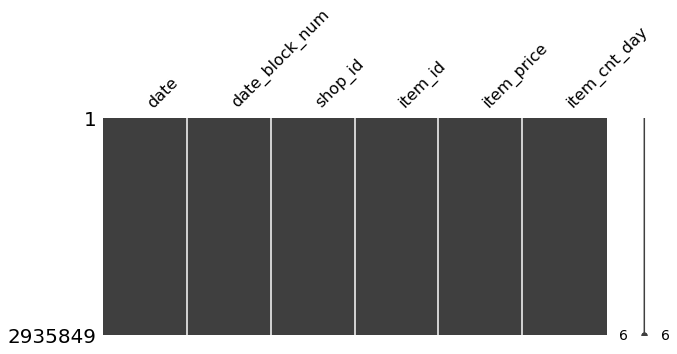

In [ ]:
msno.matrix(df_first, figsize=(10, 4))

In [ ]:
# Checking for missing values
df_first.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Drop unnecessary columns

In [ ]:
df_dropped = df_first.drop(['date','item_price'], axis=1)
df_dropped.head(3)

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1.0
1,0,25,2552,1.0
2,0,25,2552,-1.0


In [ ]:
df_forecast_dropped = df_test_first.drop(['ID'], axis=1)
df_forecast_dropped.head(3)

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233


Checking zero variance features

In [ ]:
### It will zero variance features
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(df_dropped)
df_dropped.columns[var_thres.get_support()]

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_day'], dtype='object')

In [ ]:
constant_columns = [column for column in df_dropped.columns
                    if column not in df_dropped.columns[var_thres.get_support()]]

print(len(constant_columns))

0


In [ ]:
df_dropped = df_dropped.drop(constant_columns,axis=1)
df_dropped.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1.0
1,0,25,2552,1.0
2,0,25,2552,-1.0
3,0,25,2554,1.0
4,0,25,2555,1.0


Check categorical columns

In [ ]:
# There is no categorical columns in the dataframe
categorical_feature_columns = list(set(df_dropped.columns) - set(df_dropped._get_numeric_data().columns))
categorical_feature_columns

[]

In [ ]:
numerical_feature_columns = list(df_dropped._get_numeric_data().columns)
numerical_feature_columns

['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']

In [ ]:
for col in df_dropped:
    unique_vals = np.unique(df_dropped[col])
    nr_values = len(unique_vals)
    if nr_values < 10:
        print(f'The number of values for feature {col} :{nr_values} -- {unique_vals}')
    else:
        print(f'The number of values for feature {col} :{nr_values}')

The number of values for feature date_block_num :34
The number of values for feature shop_id :60
The number of values for feature item_id :21807
The number of values for feature item_cnt_day :198


 Create train and test datasets

In [ ]:
df_group = df_dropped.groupby(['date_block_num', 'shop_id', 'item_id']).sum().reset_index()
df_group.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [ ]:
df_train = df_group.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day', 
                        fill_value=0)
df_train.reset_index(inplace=True)
df_train.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,30,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_test = pd.merge(df_forecast_dropped, df_train, on=['shop_id','item_id'], how='left').fillna(0)
df_test.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Regressions and Results

In [ ]:
X = df_train[df_train.columns[:-1]].values
y = df_train[df_train.columns[-1]]
print(X.shape)
print(y.shape)

(424124, 35)
(424124,)


Separate the dataset into train and test

In [ ]:
# first one
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.15, random_state=15)

# Second one
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size = 0.9, test_size=0.1, random_state=15)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(305369, 35)
(63619, 35)
(33930, 35)
(305369,)
(63619,)
(33930,)


Running Machine Learning Models

 Logistic Regression

In [ ]:
log_reg = LogisticRegression().fit(X_train, y_train)

In [ ]:
# Accuracy on Validation
print('The Validation Accuracy is: {:.1%}'.format(log_reg.score(X_valid, y_valid)))
print('The Validation MSE is: {:.4}'.format(mean_squared_error(y_valid, log_reg.predict(X_valid))))

# Accuracy on Test
print('The Testing Accuracy is: {:.1%}'.format(log_reg.score(X_test, y_test)))
print('The Testing MSE is: {:.4}'.format(mean_squared_error(y_test, log_reg.predict(X_test))))

The Validation Accuracy is: 92.6%
The Validation MSE is: 9.118
The Testing Accuracy is: 92.6%
The Testing MSE is: 84.72


 Stochastic Gradient Descent

In [ ]:
SGDC_reg = SGDClassifier().fit(X_train, y_train)

In [ ]:
# Accuracy on Validation
print('The Validation Accuracy is: {:.1%}'.format(SGDC_reg.score(X_valid, y_valid)))
print('The Validation MSE is: {:.8}'.format(mean_squared_error(y_valid, SGDC_reg.predict(X_valid))))

# Accuracy on Test
print('The Testing Accuracy is: {:.1%}'.format(SGDC_reg.score(X_test, y_test)))
print('The Testing MSE is: {:.8}'.format(mean_squared_error(y_test, SGDC_reg.predict(X_test))))

The Validation Accuracy is: 92.2%
The Validation MSE is: 25.66761
The Testing Accuracy is: 92.2%
The Testing MSE is: 92.406231


 DecisionTreeClassifier

In [ ]:
dtc_reg = DecisionTreeClassifier().fit(X_train, y_train)
# Accuracy on Validation
print('The Validation Accuracy is: {:.1%}'.format(dtc_reg.score(X_valid, y_valid)))
print('The Validation MSE is: {:.4}'.format(mean_squared_error(y_valid, dtc_reg.predict(X_valid))))

# Accuracy on Test
print('The Testing Accuracy is: {:.1%}'.format(dtc_reg.score(X_test, y_test)))
print('The Testing MSE is: {:.8}'.format(mean_squared_error(y_test, dtc_reg.predict(X_test))))

The Validation Accuracy is: 90.1%
The Validation MSE is: 4.024
The Testing Accuracy is: 90.0%
The Testing MSE is: 69.714032


RandomForestRegressor

In [ ]:
rfr_reg = RandomForestRegressor().fit(X_train, y_train)


In [ ]:
# Accuracy on Validation
print('The Validation Accuracy is: {:.1%}'.format(rfr_reg.score(X_valid, y_valid)))
print('The Validation MSE is: {:.4}'.format(mean_squared_error(y_valid, rfr_reg.predict(X_valid))))

# Accuracy on Test
print('The Testing Accuracy is: {:.1%}'.format(rfr_reg.score(X_test, y_test)))
print('The Testing MSE is: {:.8}'.format(mean_squared_error(y_test, rfr_reg.predict(X_test))))

The Validation Accuracy is: 68.6%
The Validation MSE is: 2.85
The Testing Accuracy is: 9.9%
The Testing MSE is: 76.281914


*** Final result ***
predictions


In [ ]:
X_forecast = df_test[df_test.columns[:-1]].values
y_forecast_pred = rfr_reg.predict(X_forecast)
y_forecast_pred = list(map(round, y_forecast_pred))

In [ ]:
y_forecast_pred[:20]

[0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 0, 0, 2, 4, 1, 0, 2, 0]

In [ ]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['ID'] = df_test_first['ID']
submission['item_cnt_month'] = y_forecast_pred # predictions on the test dataset
submission.head()

,ID,item_cnt_month
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1


In [ ]:
# Convert submisison dataframe to csv 
submission.to_csv('predict_future_sales.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [ ]:
# Check the  csv format 
submissions_check = pd.read_csv("predict_future_sales.csv")
submissions_check.head()

,ID,item_cnt_month
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1


References : 

https://www.kaggle.com/lalbabusah/predict-future-sales

https://www.youtube.com/watch?v=f1y9wDDxWnA

https://www.youtube.com/watch?v=uMlU2JaiOd8&t=644s

https://www.youtube.com/watch?v=0HDy6n3UD5M&t=1s